# **<span style="color: RED;">THỰC HÀNH 5: XÁC ĐỊNH ĐỐI TƯỢNG TRONG ẢNH</span>**

## **<span style="color: RED;">1. CÀI ĐẶT THƯ VIỆN</span>**

In [1]:
%pip install opencv-python

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: C:\Users\ASUS ROG STRIX\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


## **<span style="color: RED;">2. VIẾT CHƯƠNG TRÌNH GÁN NHÃN ẢNH</span>**

### 2.1 Gán nhãn ảnh

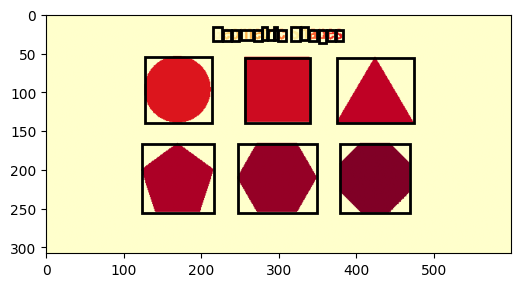

In [2]:
from PIL import Image
import numpy as np
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

# Đọc ảnh thang xám
data = Image.open('geometric.png').convert('L')
a = np.asarray(data)

# Phân ngưỡng bằng phương pháp Otsu
thres = threshold_otsu(a)
b = a > thres  # giữ lại những điểm ảnh vượt ngưỡng

# Gán nhãn các vùng liên thông
c = label(b)
cl = Image.fromarray(c.astype(np.uint8))
iio.imsave('label_output.jpg', cl)

# Phân tích đặc trưng của từng vùng
d = regionprops(c)

# Hiển thị ảnh cùng các hộp bao quanh
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(c, cmap='YlOrRd')
for i in d:
    lr, lc, ur, uc = i['BoundingBox']
    rec_width = uc - lc
    rec_height = ur - lr
    rect = mpatches.Rectangle((lc, lr), rec_width, rec_height, fill=False,
                              edgecolor='black', linewidth=2)
    ax.add_patch(rect)
plt.show()

### 2.2 Dò tìm cạnh theo chiều dọc

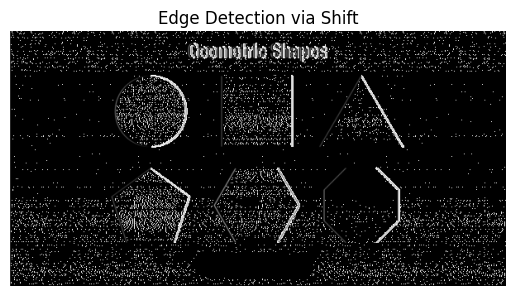

In [3]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd

# Đọc ảnh và chuyển sang ảnh xám
data = Image.open('geometric.png').convert('L')
a = np.array(data)

# Tính toán biên bằng cách lấy hiệu ảnh gốc và ảnh đã dịch sang phải 1 pixel
bmg = np.abs(a - nd.shift(a, shift=(0, 1), order=0))

# Hiển thị ảnh biên
plt.imshow(bmg, cmap='gray')
plt.title('Edge Detection via Shift')
plt.axis('off')
plt.show()

### 2.3	Dò tìm cạnh với Sobel Filter

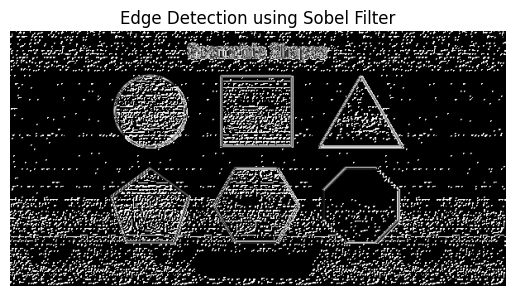

In [4]:
from PIL import Image
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

# Đọc ảnh
data = Image.open('geometric.png').convert('L')
img = np.array(data)

# Áp dụng bộ lọc Sobel
sobel_x = nd.sobel(img, axis=0)   # dọc
sobel_y = nd.sobel(img, axis=1)   # ngang

# Tổng độ lớn biên
edge_magnitude = np.abs(sobel_x) + np.abs(sobel_y)

# Hiển thị ảnh biên
plt.imshow(edge_magnitude, cmap='gray')
plt.title('Edge Detection using Sobel Filter')
plt.axis('off')
plt.show()

### 2.4	Xác định góc của đối tượng

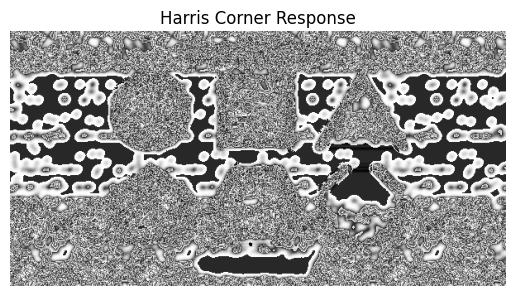

In [5]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd

def Harris(indata, alpha=0.2):
    x = nd.sobel(indata, axis=0)
    y = nd.sobel(indata, axis=1)
    xl = x ** 2
    yl = y ** 2
    xy = x * y

    # Làm mượt bằng Gaussian filter
    xl = nd.gaussian_filter(xl, sigma=3)
    yl = nd.gaussian_filter(yl, sigma=3)
    xy = nd.gaussian_filter(xy, sigma=3)

    # Tính toán ma trận đặc trưng và phản hồi Harris
    detC = xl * yl - xy**2
    trC = xl + yl
    R = detC - alpha * trC**2
    return R

# Đọc và chuyển ảnh thành mảng grayscale
data = Image.open('geometric.png').convert('L')
img_array = np.array(data)

# Áp dụng hàm Harris
response = Harris(img_array)

# Hiển thị kết quả
plt.imshow(response, cmap='gray')
plt.title('Harris Corner Response')
plt.axis('off')
plt.show()

### 2.5	Dò tìm hình dạng cụ thể trong ảnh với Hough Transform

##### 2.5.1	Dò tìm đường thẳng trong ảnh

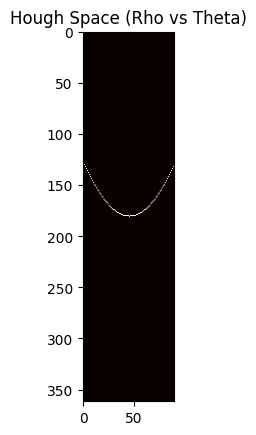

In [6]:
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.filters.thresholding import threshold_otsu

def LineHough(data, gamma):
    V, H = data.shape
    R = int(np.sqrt(V * V + H * H))  # Độ dài đường chéo ảnh
    ho = np.zeros((R, 90), float)    # Hough space: trục rho x theta

    w = data.copy()
    ok = True
    theta = np.arange(90) / 180.0 * np.pi  # góc từ 0° đến 90° đổi sang radian
    tp = np.arange(90).astype(float)

    while ok:
        mx = w.max()
        if mx < gamma:
            ok = False
        else:
            v, h = divmod(w.argmax(), H)
            y = V - v
            x = h
            rh = x * np.cos(theta) + y * np.sin(theta)
            for i in range(len(rh)):
                r_idx = int(rh[i])
                t_idx = int(tp[i])
                if 0 <= r_idx < R and 0 <= t_idx < 90:
                    ho[r_idx, t_idx] += mx
            w[v, h] = 0  # loại điểm đã xử lý
    return ho

# Dữ liệu đầu vào — ảnh nhị phân đơn giản với 1 điểm tại (128,128)
data = np.zeros((256, 256))
data[128, 128] = 1

# Áp dụng Hough Transform
bmg = LineHough(data, 0.5)

# Hiển thị Hough space
plt.imshow(bmg, cmap='hot')
plt.title('Hough Space (Rho vs Theta)')
plt.axis('on')
plt.show()

##### 2.5.2 Dò tìm đường tròn trong ảnh

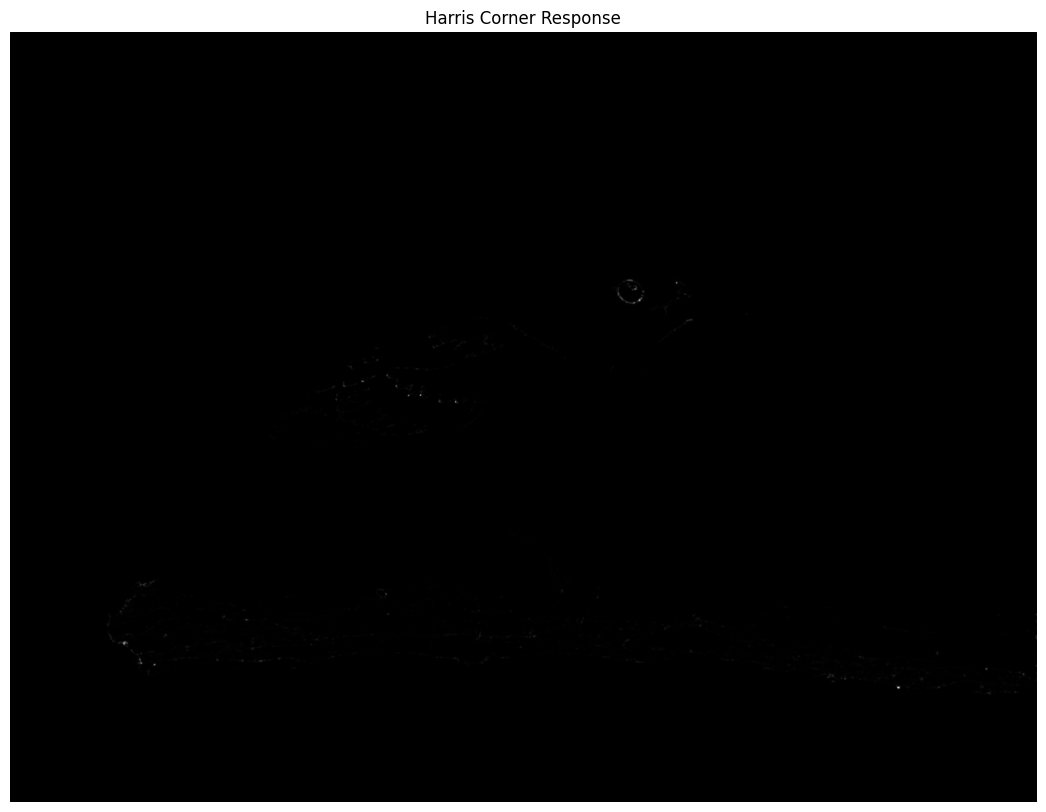

In [7]:
from PIL import Image
import numpy as np
import cv2
import imageio.v2 as iio
import scipy.ndimage as nd
from skimage.morphology import label
from skimage.measure import regionprops
import matplotlib.pylab as plt
import matplotlib.patches as mpatches
from skimage.feature import corner_harris
from skimage.color import rgb2gray

# Đọc ảnh và chuyển sang ảnh xám
data = iio.imread('bird.png')
image_gray = rgb2gray(data)

# Áp dụng thuật toán Harris Corner Detection
coordinate = corner_harris(image_gray, k=0.001)

# Hiển thị ảnh phản hồi góc
plt.figure(figsize=(20, 10))
plt.imshow(coordinate, cmap='gray')
plt.axis('off')
plt.title('Harris Corner Response')
plt.show()

### 2.6	Image matching

    Tìm điểm tương đồng giữa 2 ảnh
    - Tìm điểm cần so sánh (Harris Corner Detector)   
    - Xem xét vùng chọn hình chữ nhật xung quanh những điểm cần so sánh
    - Tính mô tả đặc trưng cục bộ cho mỗi điểm của mỗi ảnh
    - Kiểm tra độ tương đồng giữa hai ảnh


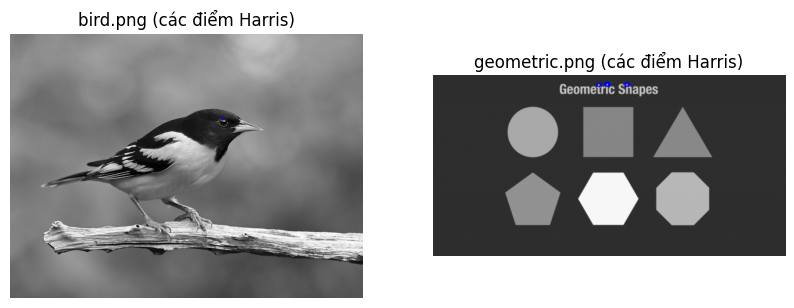

Số cặp điểm tương đồng tìm được: 20


In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Đọc ảnh
img1 = cv2.imread('bird.png', 0)
img2 = cv2.imread('geometric.png', 0)

# 1. Tìm điểm cần so sánh (Harris Corner Detector)
harris1 = cv2.cornerHarris(np.float32(img1), 2, 3, 0.04)
harris2 = cv2.cornerHarris(np.float32(img2), 2, 3, 0.04)

# Lấy toạ độ các điểm Harris mạnh nhất
pts1 = np.argwhere(harris1 > 0.01 * harris1.max())
pts2 = np.argwhere(harris2 > 0.01 * harris2.max())

# 2. Xem xét vùng chọn hình chữ nhật xung quanh những điểm cần so sánh
patch_size = 11  # patch 11x11
half = patch_size // 2

def get_patches(img, pts):
    patches = []
    for y, x in pts:
        if y-half >= 0 and y+half < img.shape[0] and x-half >= 0 and x+half < img.shape[1]:
            patch = img[y-half:y+half+1, x-half:x+half+1].flatten()
            patches.append((y, x, patch))
    return patches

patches1 = get_patches(img1, pts1)
patches2 = get_patches(img2, pts2)

# 3. Tính mô tả đặc trưng cục bộ cho mỗi điểm (vector pixel của patch)
# 4. Kiểm tra độ tương đồng giữa hai ảnh (so khớp bằng SSD)

matches = []
for y1, x1, desc1 in patches1[:20]:  # chỉ lấy 20 điểm đầu cho nhanh
    best_dist = 1e10
    best = None
    for y2, x2, desc2 in patches2[:20]:
        dist = np.sum((desc1 - desc2) ** 2)
        if dist < best_dist:
            best_dist = dist
            best = (y2, x2)
    matches.append(((y1, x1), best))

# Vẽ các cặp điểm tương đồng lên ảnh
img1_color = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
img2_color = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
for (y1, x1), (y2, x2) in matches:
    cv2.circle(img1_color, (x1, y1), 4, (0,0,255), 1)
    cv2.circle(img2_color, (x2, y2), 4, (0,0,255), 1)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img1_color)
plt.title('bird.png (các điểm Harris)')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img2_color)
plt.title('geometric.png (các điểm Harris)')
plt.axis('off')
plt.show()

print(f'Số cặp điểm tương đồng tìm được: {len(matches)}')

Số điểm Harris trên bird.png: 20
Số điểm Harris trên geometric.png: 20


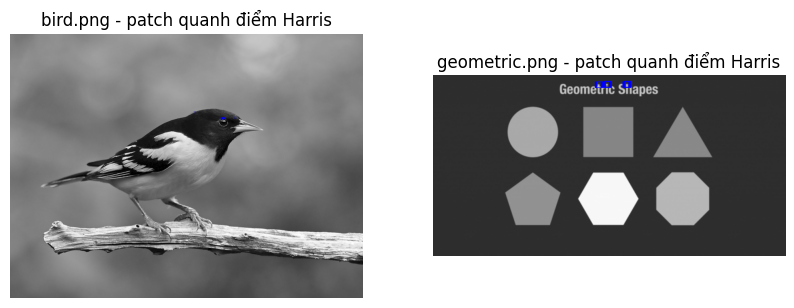

Vector đặc trưng patch đầu tiên bird.png: [153 156 153 154 157 155 156 163 158 160 156 152 153 157 160 163 157 144
 135 123 111  96 145 135 119 119 119 109 102  98  90  93  85 117 110  89
  85  95 106 117 112 102  98  82 110 130 142 158 152 127 101  82  56  46
  53 159 162 159 153 140 102  39  21  34  43  46 151 133 111  87  82  64
  39  34  50  56  46 109  92  74  50  43  34  34  34  43  50  53  66  39
  34  34  34  28  34  43  39  39  46  28  28  34  50  43  39  39  43  39
  39  39  39  46  43  39  39  39  28  34  43  39  43]
Vector đặc trưng patch đầu tiên geometric.png: [ 46  46  46  46  46  46  46  46  46  46  46  45  46  46  46  46  45  46
  45  46  46  45  46  46  46  46  46  46  46  46  46  46  46  46  46  46
  46  46  46  46  46  46  46  46  46  46  46  46  46  48  49  48  47  46
  46  46  45  45  46  56 131 149 143  81  46  46  46  45  46  45  61 171
 198 190  97  45  46  46  46  46  46  59 155 179 171  91  46  46  46  46
  50  51  49  68  73  72  55  46  45  74  85 137 118  

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Đọc ảnh và tìm điểm Harris
img1 = cv2.imread('bird.png', 0)
img2 = cv2.imread('geometric.png', 0)

harris1 = cv2.cornerHarris(np.float32(img1), 2, 3, 0.04)
harris2 = cv2.cornerHarris(np.float32(img2), 2, 3, 0.04)

# Lấy các điểm Harris mạnh nhất (chỉ lấy 20 điểm đầu cho đơn giản)
pts1 = np.argwhere(harris1 > 0.01 * harris1.max())[:20]
pts2 = np.argwhere(harris2 > 0.01 * harris2.max())[:20]

# 2. Lấy patch 11x11 quanh mỗi điểm
patch_size = 11
half = patch_size // 2

def extract_patches(img, pts):
    patches = []
    coords = []
    for y, x in pts:
        if y-half >= 0 and y+half < img.shape[0] and x-half >= 0 and x+half < img.shape[1]:
            patch = img[y-half:y+half+1, x-half:x+half+1].flatten()
            patches.append(patch)
            coords.append((y, x))
    return np.array(patches), coords

patches1, coords1 = extract_patches(img1, pts1)
patches2, coords2 = extract_patches(img2, pts2)

# 3. Tính mô tả đặc trưng: vector pixel của patch
# (patches1, patches2 đã là vector đặc trưng)

# 4. So khớp từng patch của ảnh 1 với tất cả patch của ảnh 2 bằng SSD
matches = []
for i, desc1 in enumerate(patches1):
    best_dist = 1e10
    best_j = -1
    for j, desc2 in enumerate(patches2):
        dist = np.sum((desc1 - desc2) ** 2)
        if dist < best_dist:
            best_dist = dist
            best_j = j
    matches.append((i, best_j, best_dist))

# 5. Hiển thị kết quả từng bước
print(f"Số điểm Harris trên bird.png: {len(coords1)}")
print(f"Số điểm Harris trên geometric.png: {len(coords2)}")

# Vẽ điểm Harris lên ảnh
img1_show = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
img2_show = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
for y, x in coords1:
    cv2.rectangle(img1_show, (x-half, y-half), (x+half, y+half), (0,0,255), 1)
for y, x in coords2:
    cv2.rectangle(img2_show, (x-half, y-half), (x+half, y+half), (0,0,255), 1)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(img1_show)
plt.title('bird.png - patch quanh điểm Harris')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img2_show)
plt.title('geometric.png - patch quanh điểm Harris')
plt.axis('off')
plt.show()

# Hiển thị vector đặc trưng của patch đầu tiên mỗi ảnh
print('Vector đặc trưng patch đầu tiên bird.png:', patches1[0])
print('Vector đặc trưng patch đầu tiên geometric.png:', patches2[0])

# In ra các cặp điểm tương đồng nhất
print('Các cặp điểm tương đồng nhất:')
for idx, (i, j, dist) in enumerate(matches):
    y1, x1 = coords1[i]
    y2, x2 = coords2[j]
    print(f'Cặp {idx+1}: bird({y1},{x1}) <-> geo({y2},{x2}), SSD={dist:.0f}')
print(f'Tổng số cặp điểm tương đồng: {len(matches)}')